In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from sklearn import metrics
from sklearn import model_selection


In [2]:
# Load the data from Chavez, et al. (2017)
chavez_dt = pd.read_csv('data/chavez_data.csv')

# questionnaire design
pregunta = np.array([54,0,55,117,55,0,75,61,19,0,25,53,31,0,85,7,
                     14,0,25,19,47,0,50,160,15,0,35,13,25,0,60,14,
                     78,0,80,162,40,0,55,62,11,0,30,7,67,0,75,119,
                     34,0,35,186,27,0,50,21,69,0,85,91,49,0,60,89,
                     80,0,85,157,24,0,35,29,33,0,80,14,28,0,30,179,
                     34,0,50,30,25,0,30,80,41,0,75,20,54,0,60,111,
                     54,0,80,30,22,0,25,136,20,0,55,7]).reshape(27, 4)

condition_col = np.array(['DT'+str(i) for i in range(1, 28)]).reshape(-1,1)
pregunta = np.hstack((condition_col,pregunta))
pregunta = pd.DataFrame(pregunta)
condition_col_name = ['ss_x','ss_t','ll_x','ll_t']
pregunta.columns = ['condition'] + condition_col_name

# object containing participants' choices: '0' is choice of SS, '1' is choice of 'LL'
chavez_dt = pd.melt(chavez_dt, id_vars=['ID','School'], var_name='condition', value_name='choice')
chavez_dt = pd.merge(chavez_dt,pregunta,on='condition')
chavez_dt[condition_col_name] = chavez_dt[condition_col_name].apply(pd.to_numeric)
chavez_dt.columns = ['person_id','school','condition','choice'] + condition_col_name

# Define features, label, and group variable
features = ['ss_x', 'll_x', 'll_t',
            'abs_diff_x', 'rel_diff_x', 'growth_x']
label = 'choice'
group = 'person_id'

data_prepare = cross_valid.data_prepare(data=chavez_dt,feature=features,label=label,group=group)
data_prepare.generate_features()
dataset = data_prepare._data

# Split the data into train sample and test sample
# Train sample containts 80% of the participants, test sample contains the rest 
X_train,X_test,y_train,y_test = data_prepare.split_sample(test_size=0.2)
groups = data_prepare.train_sample[group]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=X_train,y=y_train,groups=groups))

In [3]:
len(set(dataset['person_id']))

1284

In [4]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
# The following dictionary directly shows the tuning results 
param_grid = {'n_estimators': [40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, 
                                           cv=cv, 
                                           scoring=["accuracy","neg_log_loss",'neg_mean_absolute_error','neg_mean_squared_error'], 
                                           refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=X_train,y=y_train,groups=groups)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=[(array([    1,     2,     3, ..., 27613, 27614, 27615]),
                  array([    0,     8,    27, ..., 27606, 27611, 27616])),
                 (array([    0,     1,     2, ..., 27613, 27615, 27616]),
                  array([    7,    12,    17, ..., 27559, 27581, 27614])),
                 (array([    0,     1,     2, ..., 27614, 27615, 27616]),
                  array([   20,    24,    30, ..., 27593, 27595, 27608])),
                 (array([    0,     1,     2, ..., 27614, 27615, 27616]),
                  array([    3,    21,    25, ..., 27579, 27603, 27604])),
                 (array([    0,     1,     2, ..., 276...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [40], 'reg_lambda': [0.7],
                         'subsample': [0.55]},
             refit='neg_log_loss',
             scoring=['accuracy', 'neg_log_loss', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'],
             verbose=3)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

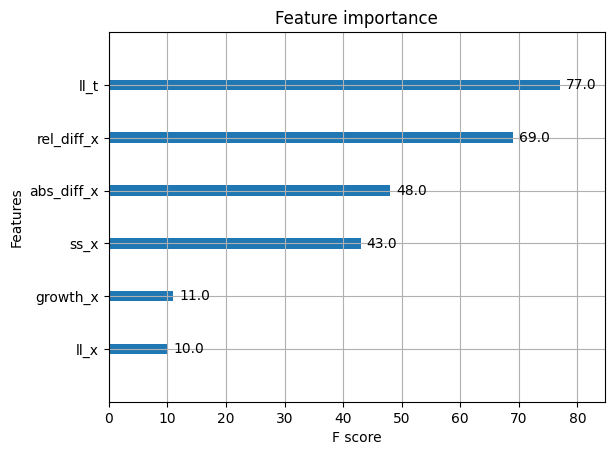

In [5]:
# Save the XGBoost model and check the feature importance
bst_model = grid_search.best_estimator_

with open('my_model_2.pkl', 'wb') as f:
    pickle.dump(bst_model, f)


heuristic_kf_dict = {'dstyle': 'heuristic',
            'ustyle': '--',
            'params': None,
            'accuracy': grid_search.cv_results_['mean_test_accuracy'][0],
            'log_loss': -grid_search.cv_results_['mean_test_neg_log_loss'][0],
            'mse':-grid_search.cv_results_['mean_test_neg_mean_squared_error'][0],
            'mae':-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][0]
            }

xgb.plot_importance(bst_model)

In [6]:
# Plot a decision tree
# To check structure of different trees, change num_trees 
#xgb.to_graphviz(bst_model, num_trees=1)

In [7]:
# Fit data by distounted utility model and trade-off model
style_list = cross_valid.estimation.gen_style_list()
train_sample = data_prepare.train_sample

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [1:51:29<00:00, 30.41s/it]  


In [8]:
# Check if some of the fits fail to converge 
np.where(kf.success==False)

(array([], dtype=int64),)

In [9]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result = kf_result_df.drop('style',axis=1)
kf_result = pd.concat([kf_result,pd.DataFrame(heuristic_kf_dict,index=[99])]).sort_values('log_loss')
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
99,heuristic,--,None,0.220935,0.220935,0.479879,0.779065,NaN
21,trade,power,"[5.434, 2.114, 0.011, 3.195, 0.285, 0.381]",0.156967,0.313629,0.483268,0.782422,0.278818
11,hb2,power,"[0.325, 0.002, 0.008, 0.004]",0.157673,0.314628,0.484930,0.774997,0.320255
7,expo2,power,"[0.697, 0.792, 0.552, 0.111, 0.123]",0.157703,0.314873,0.485127,0.779791,0.292838
1,attention,power,"[0.984, 1.333, 0.464, 1.933]",0.157818,0.316694,0.485639,0.782422,0.278818
13,hbmd,power,"[25.374, 0.376, 0.999]",0.157962,0.316662,0.485871,0.774002,0.325232
19,quasihb_fc,power,"[0.992, 0.997, 1.553, 0.144, 1.033]",0.158154,0.316816,0.486723,0.780988,0.287652
20,trade,cara,"[7.242, 4.947, 11.968, 12.744, 0.298, 0.21]",0.158583,0.316764,0.486850,0.771887,0.250664
3,attention_uni,power,"[0.806, 0.335, 0.821]",0.158307,0.317836,0.488037,0.782422,0.278818
9,hb,power,"[0.006, 0.25, 0.476]",0.159293,0.320000,0.489188,0.774002,0.325232


In [10]:
# Compare models: Out-of-sample performance
test_sample = data_prepare.test_sample
test_result = cross_valid.get_result_tab(kf_result_df,test_sample)

with open('my_model_2.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

heuristic_test_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,X_test=X_test,y_test=y_test)

test_result = pd.concat([test_result,pd.DataFrame(heuristic_test_dict,index=[99])]).sort_values('accuracy',ascending=False)
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.163483,0.322077,0.499615,0.767469,0.295303
21,trade,power,0.164880,0.316253,0.504387,0.766309,0.258191
1,attention,power,0.165340,0.326326,0.504837,0.763410,0.332125
3,attention_uni,power,0.165079,0.324718,0.506047,0.763410,0.332125
9,hb,power,0.166515,0.326945,0.508271,0.757321,0.332415
19,quasihb_fc,power,0.206302,0.447583,0.603855,0.757321,0.332415
17,quasihb,power,0.179942,0.397427,0.543460,0.757321,0.332415
15,hce,power,0.167339,0.334905,0.509620,0.757321,0.332415
13,hbmd,power,0.165489,0.327454,0.504947,0.757321,0.332415
12,hbmd,cara,0.166941,0.329414,0.508917,0.757321,0.332415


In [12]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = chavez_dt[chavez_dt.index.isin(np.random.choice(chavez_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_prepare = cross_valid.data_prepare(data=rda_sample)
rda_prepare.generate_features()
rda_sample = rda_prepare._data[features]
rda_sample['ss_t'] = 0
rda_sample[label] = heuristic_model.predict(rda_sample[features])

rda_result = cross_valid.get_result_tab(kf_result_df,rda_sample)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
21,trade,power,0.064503,0.214233,0.257742,0.962,0.226
3,attention_uni,power,0.071507,0.228161,0.276739,0.959,0.305
1,attention,power,0.075320,0.233626,0.285608,0.959,0.305
9,hb,power,0.079988,0.239121,0.294649,0.955,0.309
19,quasihb_fc,power,0.183242,0.424194,0.556901,0.955,0.309
17,quasihb,power,0.132157,0.348823,0.441415,0.955,0.309
15,hce,power,0.087533,0.253642,0.314921,0.955,0.309
13,hbmd,power,0.076004,0.236831,0.288813,0.955,0.309
12,hbmd,cara,0.074824,0.237375,0.288453,0.955,0.309
11,hb2,power,0.078729,0.252597,0.306240,0.955,0.309


In [ ]:
# Use the prediction value by magnitude-dependent hyperbolic (hbmd) with power utillity as the label
# Examine which model can explain the hbmd's prediction the best
target_kf_row = kf_result_df[(kf_result_df['dstyle']=='trade') & (kf_result_df['ustyle']=='power')]
target_style = target_kf_row['style'].values[0]
target_params = target_kf_row['params'].values[0]

choice_prob = cross_valid.test_model(style=target_style,params=target_params,test_sample=rda_sample,output='predict_proba')
rda_sample[label] = (choice_prob >.5)

rda_result_2 = cross_valid.get_result_tab(kf_result_df,rda_sample).iloc[1:,:]
heuristic_rda_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,test_sample=rda_sample)
rda_result_2 = pd.concat([rda_result_2,pd.DataFrame(heuristic_rda_dict,index=[99])]).sort_values('accuracy',ascending=False)
rda_result_2

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.104826,0.302410,0.374942,0.957,0.245
13,hbmd,power,0.115726,0.321769,0.402108,0.943,0.203
9,hb,power,0.129027,0.342133,0.433830,0.928,0.224
15,hce,power,0.134387,0.351601,0.447140,0.928,0.224
19,quasihb_fc,power,0.113634,0.316495,0.396258,0.921,0.209
17,quasihb,power,0.125218,0.338202,0.426023,0.921,0.209
5,expo,power,0.133404,0.349697,0.444744,0.907,0.253
3,attention_uni,power,0.140181,0.351367,0.454956,0.879,0.137
1,attention,power,0.153357,0.368871,0.482425,0.864,0.126
20,trade,cara,0.148722,0.364771,0.478470,0.860,0.102


In [ ]:
# Save the results
kf_result.to_csv("chavez_result_kf.csv",index=False)
test_result.to_csv("chavez_result_test.csv",index=False)
rda_result.to_csv("chavez_result_rda.csv",index=False)